 ### Understand correlation and causation among time series
 
 #### Case study:
 - How to look for correlations among variables over time?
 - How to investigate causation?
 - How to predict behaviour and test accuray?  
 
 
 #### Problem framing:  
 Unveiling correlation and causation among socio-economic variables is key for enhancing data-driven poliy making.
 This exercise is a first step in building a model that looks at key indiators overtimes to identify patterns and predict positive impact

#### Resources:
- Statistical model: [Wage Growth and the Inflation Process: An Empirical Approach](https://link.springer.com/chapter/10.1007/978-1-349-23529-2_5)  
- Code examples:   
[Time Series Forecasting using Granger’s Causality and Vector Auto-regressive Model](https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6)  
[An End-to-End Project on Time Series Analysis and Forecasting](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)



In [62]:
import pandas as pd
import world_bank_data as wb # documentation: https://pypi.org/project/world-bank-data/
pd.set_option('display.max_rows', 21)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

As a starting point, we'll look at 8 main socio-economic time series from Italy dataset 1970-2020.
Looking initially at a single country to isolate noise and focus on the statistical model
Next step: build a multy-country model (by region?)

In [63]:
# Define Indicators: WB API name
indicators = {'elect_cons': 'EG.USE.ELEC.KH.PC', # electric power consumption
              'urb_pop': 'SP.URB.TOTL.IN.ZS', # urban population
              'gdp_cap': 'NY.GDP.PCAP.CD', # gdp per capita
              'school_enr':'SE.SEC.ENRR', # school enrollment, secondary
              'tax_rev':'GC.TAX.TOTL.GD.ZS', # tax revenue (% GDP)
              'frgn_inv':'BX.KLT.DINV.CD.WD', # foreign investments (%GDP)
              'life_exp':'SP.DYN.LE00.IN', #life expetancy at birth
              'exp':'NE.EXP.GNFS.ZS'} # export of good and services (% GDP)

df = pd.DataFrame()

# export single series, convert dataframe, append and iterate through indicators
for i in indicators:
    ind_series = wb.get_series(indicators[i], country='ITA', date='1970:2020', id_or_value='id', simplify_index=True).rename(i).to_frame()
    if not df.empty:
        df = df.join(ind_series, how='outer')
    else:
        df = ind_series
        
# Check for nulls
df.isna().sum()

elect_cons    5
urb_pop       0
gdp_cap       0
school_enr    3
tax_rev       4
frgn_inv      0
life_exp      1
exp           0
dtype: int64

In [64]:
# Fill nulls with values of previous year (if null, following year)
df = df.fillna(method='bfill')
df = df.fillna(method='ffill')
df.isna().sum()

elect_cons    0
urb_pop       0
gdp_cap       0
school_enr    0
tax_rev       0
frgn_inv      0
life_exp      0
exp           0
dtype: int64

In [65]:
df

,elect_cons,urb_pop,gdp_cap,school_enr,tax_rev,frgn_inv,life_exp,exp
Year,,,,,,,,
1970,2072.912767,64.272,2106.863953,59.88758,12.550606,6.241600e+08,71.558780,15.163538
1971,2152.773938,64.750,2305.609774,59.88758,12.550606,5.490900e+08,71.806829,15.580055
1972,2295.493059,65.039,2671.137308,62.23571,12.550606,6.731811e+08,72.075366,16.313526
1973,2457.726839,65.241,3205.252065,64.66636,12.550606,6.731030e+08,72.026341,16.105448
1974,2537.285386,65.442,3621.145839,66.50501,13.498171,5.953505e+08,72.734390,18.524019
...,...,...,...,...,...,...,...,...
2015,5002.406680,69.565,30230.226302,102.25627,24.739527,1.330344e+10,82.543902,29.715982
2016,5002.406680,69.855,30939.714246,101.66235,25.026318,2.565666e+10,83.243902,29.327891
2017,5002.406680,70.144,32406.720315,101.27041,24.634791,1.113843e+10,82.946341,30.733733


Now that the dataframe is clean, have a overview look at the time-series tends

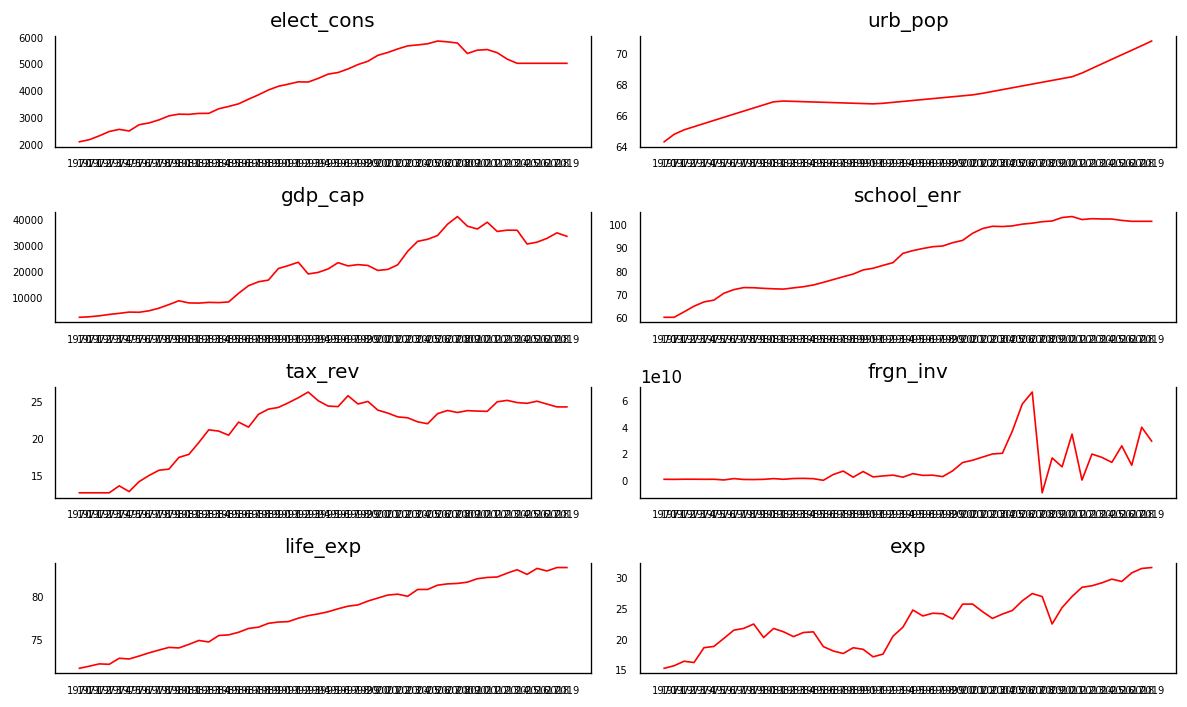

In [66]:
# Vizualize time series
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();


### Granger’s Causality test

The basis behind Vector AutoRegression is that each of the time series in the system influences each other.  
Granger’s Causality test looks at all possible combinations of the time series, stores the p-values, and checks if the past values of one series do not cause the other series.  
[Statistical model here](https://www.statisticshowto.com/granger-causality/)

In [67]:
# Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)   

,elect_cons_x,urb_pop_x,gdp_cap_x,school_enr_x,tax_rev_x,frgn_inv_x,life_exp_x,exp_x
elect_cons_y,1.0000,0.0366,0.0000,0.0128,0.0000,0.0000,0.0000,0.0074
urb_pop_y,0.0000,1.0000,0.0035,0.0008,0.0000,0.0000,0.0294,0.0001
gdp_cap_y,0.0000,0.1891,1.0000,0.0000,0.0000,0.0000,0.0000,0.0001
school_enr_y,0.0017,0.0000,0.0000,1.0000,0.0000,0.0000,0.0006,0.0079
tax_rev_y,0.0009,0.0000,0.0000,0.0000,1.0000,0.0023,0.3255,0.0000
frgn_inv_y,0.0005,0.0034,0.0001,0.0000,0.0002,1.0000,0.0000,0.0000
life_exp_y,0.0000,0.0000,0.0000,0.0034,0.0000,0.0000,1.0000,0.0000
exp_y,0.0004,0.0000,0.0008,0.0010,0.0000,0.0000,0.0000,1.0000


#### How to read:

The columns represents the predictor, the rows the response.  

If a given p-value is lower than the significance level (0.05), then, the corresponding predictor (column) causes the response (row).  

For example:  0.0366 at row 1, column 2 (less that the significance level of 0.05) suggess that urban population is a cause of electrical consumpion

Looking at the p-Values in the above table, basically all the time series in the system are interchangeably causing each other. This makes this system a good candidate for forecasting using VAR models.

#### Making the series stationary
First, let's perform a ongregation test to check for statistically significant connection between the  series.

In [68]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,4)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
elect_cons ::  3022.48   > 143.6691  =>   True
urb_pop ::  1966.9    > 111.7797  =>   True
gdp_cap ::  1043.09   > 83.9383   =>   True
school_enr ::  206.08    > 60.0627   =>   True
tax_rev ::  135.69    > 40.1749   =>   True
frgn_inv ::  73.84     > 24.2761   =>   True
life_exp ::  31.1      > 12.3212   =>   True
exp    ::  1.85      > 4.1296    =>   False


Before looking for stationarity, split into train and test for upcoming foreasting

In [173]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(46, 8)
(4, 8)


Now, iterate through the time series to make them all stationary. Stationarity of series (i.e. mean and variance do not change over time) is a prerequisite for VAR analysis.
We can do it by differencing the series once, and check if beccame stationary. Nevertheless, since all the series have to be of the same lenght, we have to differencing all of them at each loop until they're all good to go.

One common way to do it is by using the [Agumented Dickey-Fulley Test](https://machinelearningmastery.com/time-series-data-stationary-python/)

In [174]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    
        
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "elect_cons" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0131
 No. Lags Chosen       = 1
 Critical value 1%     = -3.589
 Critical value 5%     = -2.93
 Critical value 10%    = -2.603
 => P-Value = 0.2808. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "urb_pop" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.8596
 No. Lags Chosen       = 2
 Critical value 1%     = -3.593
 Critical value 5%     = -2.932
 Critical value 10%    = -2.604
 => P-Value = 0.9925. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "gdp_cap" 
    -----------------------------------------------
 Null Hypothesis: Data h

As said, let's keep differencing them until they're all stationary

In [175]:
# 1st difference
df_differenced = df_train.diff().dropna()
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "elect_cons" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.3379
 No. Lags Chosen       = 0
 Critical value 1%     = -3.589
 Critical value 5%     = -2.93
 Critical value 10%    = -2.603
 => P-Value = 0.0004. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "urb_pop" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3251
 No. Lags Chosen       = 1
 Critical value 1%     = -3.593
 Critical value 5%     = -2.932
 Critical value 10%    = -2.604
 => P-Value = 0.6176. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "gdp_cap" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Sta

In [176]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "elect_cons" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8116
 No. Lags Chosen       = 6
 Critical value 1%     = -3.621
 Critical value 5%     = -2.944
 Critical value 10%    = -2.61
 => P-Value = 0.0566. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "urb_pop" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0524
 No. Lags Chosen       = 1
 Critical value 1%     = -3.597
 Critical value 5%     = -2.933
 Critical value 10%    = -2.605
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "gdp_cap" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

In [177]:
# Third Differencing
df_differenced = df_differenced.diff().dropna()
# ADF Test on each column of 3nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "elect_cons" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.7294
 No. Lags Chosen       = 6
 Critical value 1%     = -3.627
 Critical value 5%     = -2.946
 Critical value 10%    = -2.612
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "urb_pop" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9194
 No. Lags Chosen       = 3
 Critical value 1%     = -3.61
 Critical value 5%     = -2.939
 Critical value 10%    = -2.608
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "gdp_cap" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

### Forecast
Now that all the series are stationary, let's build the forecasting model and check its acuracy.  
First of all, we use the [Akaike Information Criterion](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) how well the model fits the data set without overfitting.

There's a nice `select_order` function that also tests ‘BIC’, ‘FPE’ and ‘HQIC’. The optimal lag is the one that gives the lowest drop for all of them

In [178]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,65.77,66.13,3.644e+28,65.89
1,63.23,66.53,3.283e+27,64.33
2,59.35,65.58,1.576e+26,61.42
3,37.44,46.60,1.315e+18,40.48
4,-164.0,-151.9*,1.306e-64,-160.0
5,-146.6,-131.6,4.994e-66,-141.6
6,-151.3,-133.4,1.162e-71,-145.4
7,-149.3,-128.4,1.557e-73,-142.4
8,-144.8,-121.0,5.418e-74,-136.9
9,-143.3,-116.6,1.473e-75,-134.5


In the above model, the AIC, BIC, FPE and HQIC all drop at lag 4, then increases at 5 for dropping again at 6. Let's use lag=4

In [179]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, Jul, 2020
Time:                     10:25:16
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    43.7729
Nobs:                     40.0000    HQIC:                   36.6565
Log likelihood:          -842.586    FPE:                3.82403e+16
AIC:                      32.6263    Det(Omega_mle):     3.10755e+14
--------------------------------------------------------------------
Results for equation elect_cons
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -5.061899        13.805887           -0.367           0.714
L1.elect_cons        -0.628271         0.320639           -1.959           0.050
L1.urb_pop         -690.317267       910.533236        

### Check for residual error
Now that we have a nice stationary correlation matrix, we just have to check for Serial Correlation of Residual Errors using [Durbin Watson test](http://web.vu.lt/mif/a.buteikis/wp-content/uploads/PE_Book/4-8-Multiple-autocorrelation.html)

This a last verification that the model is able to explain the variances and patterns in the time series. If not, we can try to increase the order of the model, add more variables if possible, or just use another model.  

The Residual varies from 0 to 4. 2 is the optimal point of no serial correlation. 0 fully positive, 4 fully negative. We should aim for values close to 2

In [180]:
def adjust(val, length= 6): return str(val).ljust(length)

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

elect_cons : 2.31
urb_pop : 1.94
gdp_cap : 1.93
school_enr : 1.76
tax_rev : 2.27
frgn_inv : 1.86
life_exp : 1.93
exp    : 2.2


It's quite good. Let's forecast

In [181]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[-3.39268241e+01,  1.24000000e-01, -9.82185869e+03,
        -6.66460000e-01,  1.30298593e+00, -9.01772366e+10,
         1.48780488e-01,  5.84840258e-01],
       [ 1.66590312e+01, -6.80000000e-02,  1.01860625e+04,
         3.39986000e+00, -2.43944054e+00,  1.12892653e+11,
         5.00000000e-01, -9.61144881e-01],
       [ 2.03276532e+02, -5.70000000e-02, -4.56999227e+03,
        -2.17746000e+00,  6.17260459e-01, -7.59222706e+10,
        -4.51219512e-01,  1.47436399e+00],
       [ 7.49961280e+01,  2.00000000e-03, -4.72862173e+03,
         6.06720000e-01,  6.86192602e-01,  2.07645420e+10,
        -8.95121951e-01, -9.00157837e-02]])

In [183]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,elect_cons_2d,urb_pop_2d,gdp_cap_2d,school_enr_2d,tax_rev_2d,frgn_inv_2d,life_exp_2d,exp_2d
Year,,,,,,,,
2016,-395.924559,0.045444,3971.005021,-2.420698,0.929801,-6.161155e+10,2.186466,3.979177
2017,-141.579931,-0.091430,1740.793476,3.825839,-4.885164,1.613023e+11,-1.816871,-12.494132
2018,1136.687446,0.053875,-1624.150914,-0.397472,3.703941,-1.230914e+11,0.370770,15.215450
2019,-1045.343064,-0.005428,198.032793,-5.511300,3.919943,4.557004e+10,0.245400,-7.428750


Important: we should remember we have differenciated 3 times in order to make the series stationary. We should therefore de-differenciate 3 times

In [184]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns: 
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


df_results = invert_transformation(df_train, df_forecast, second_diff=True)
df_results.loc[:, ['elect_cons_forecast', 'urb_pop_forecast', 'gdp_cap_forecast', 'school_enr_forecast',
                   'tax_rev_forecast', 'frgn_inv_forecast', 'life_exp_forecast', 'exp_forecast']]


,elect_cons_forecast,urb_pop_forecast,gdp_cap_forecast,school_enr_forecast,tax_rev_forecast,frgn_inv_forecast,life_exp_forecast,exp_forecast
Year,,,,,,,,
2016,4606.482121,69.903444,28913.042334,99.810782,25.567783,-5.203741e+10,84.184027,34.302313
2017,4068.977630,70.150458,29336.651842,101.191133,21.510875,4.392406e+10,84.007279,26.394512
2018,4668.160586,70.451346,28136.110436,102.174012,21.157907,1.679411e+10,84.201302,33.702162
2019,4222.000478,70.746807,27133.601822,97.645591,24.724883,3.523421e+10,84.640724,33.581061


Now that the forecasts are back to the original sale, let's plot to test the predictions.

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plot

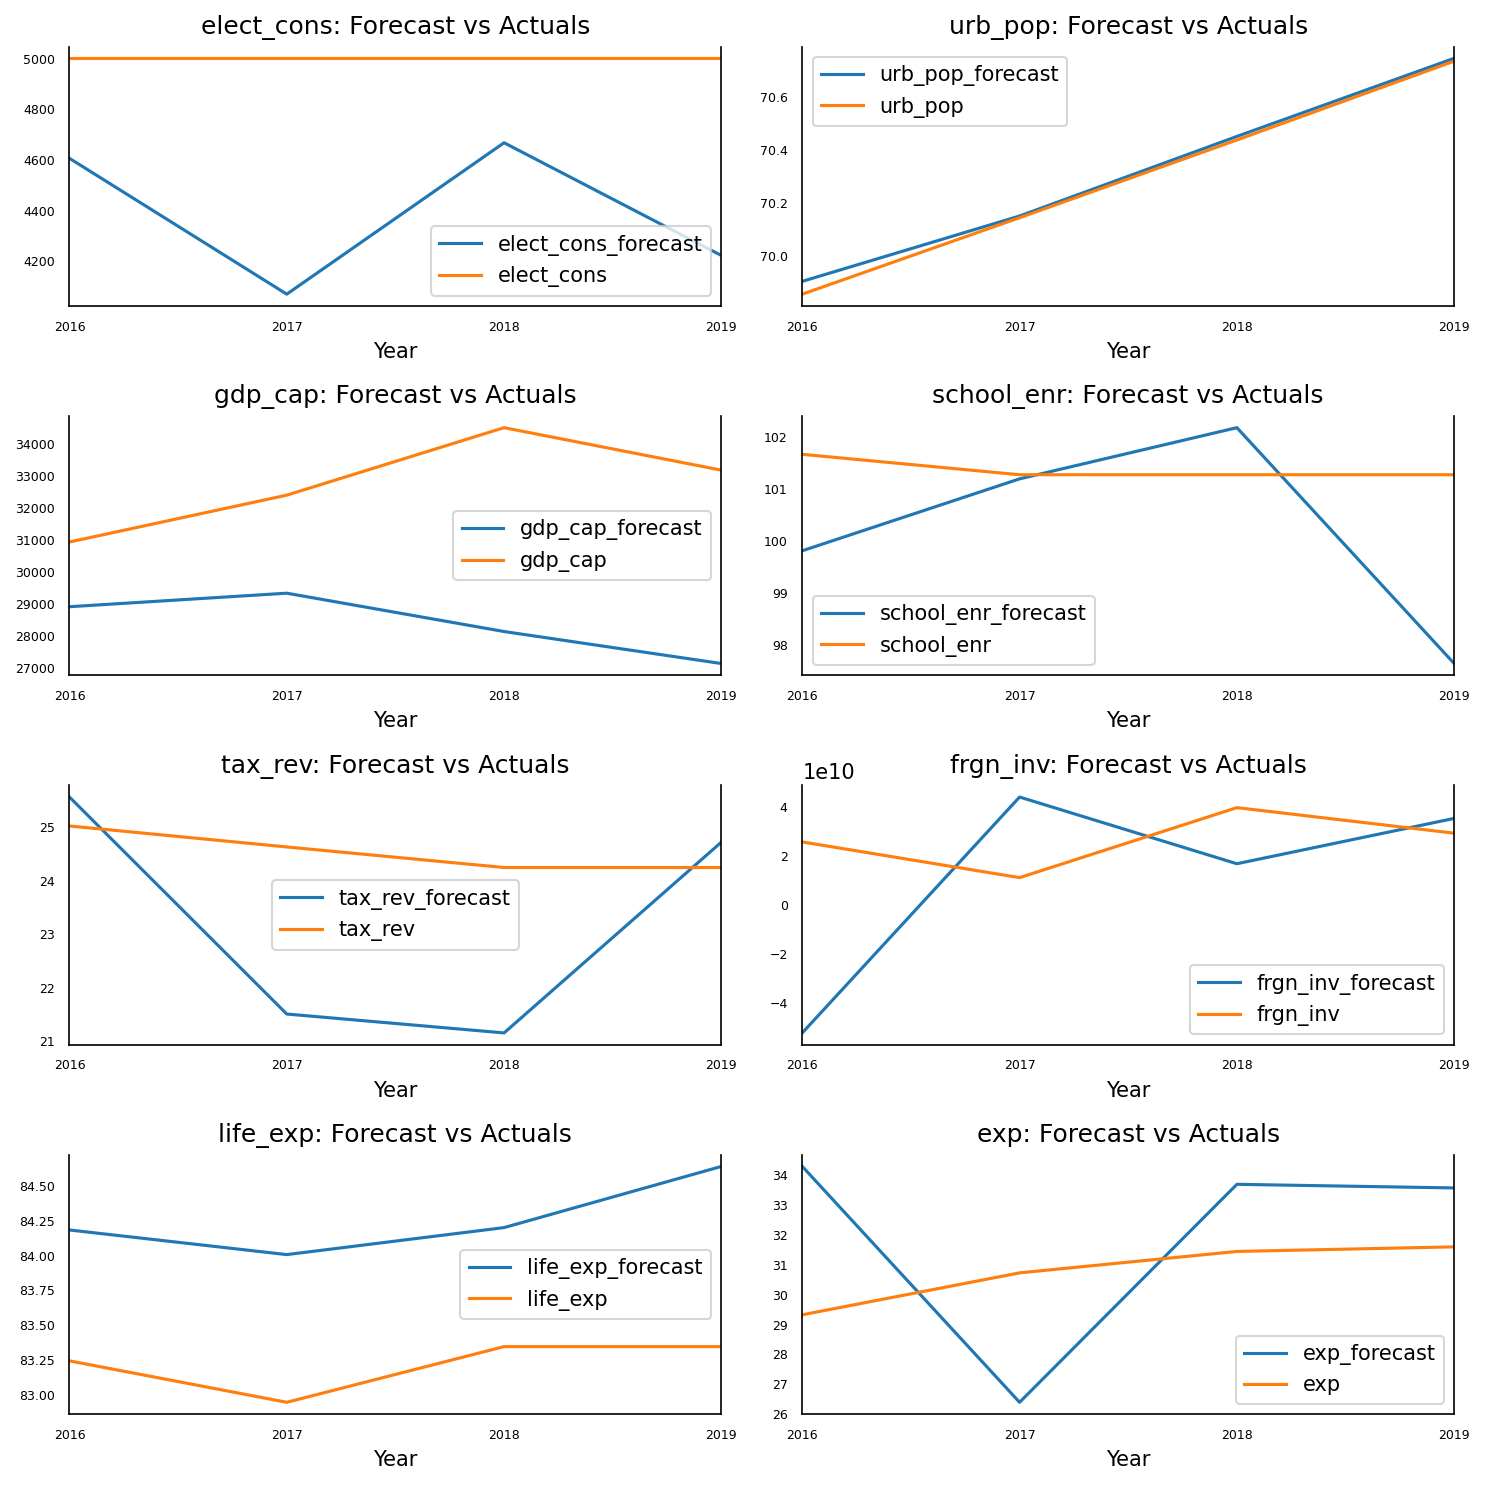

In [185]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Evaluate the forecast

In [186]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: elect_cons')
accuracy_prod = forecast_accuracy(df_results['elect_cons_forecast'].values, df_test['elect_cons'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: urb_pop')
accuracy_prod = forecast_accuracy(df_results['urb_pop_forecast'].values, df_test['urb_pop'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdp_cap')
accuracy_prod = forecast_accuracy(df_results['gdp_cap_forecast'].values, df_test['gdp_cap'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: school_enr')
accuracy_prod = forecast_accuracy(df_results['school_enr_forecast'].values, df_test['school_enr'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: tax_rev')
accuracy_prod = forecast_accuracy(df_results['tax_rev_forecast'].values, df_test['tax_rev'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: frgn_inv')
accuracy_prod = forecast_accuracy(df_results['frgn_inv_forecast'].values, df_test['frgn_inv'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: life_exp')
accuracy_prod = forecast_accuracy(df_results['life_exp_forecast'].values, df_test['life_exp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: exp')
accuracy_prod = forecast_accuracy(df_results['exp_forecast'].values, df_test['exp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: elect_cons
mape   :  0.1221
me     :  -611.0015
mae    :  611.0015
mpe    :  -0.1221
rmse   :  661.2111
corr   :  nan
minmax :  0.1221

Forecast Accuracy of: urb_pop
mape   :  0.0003
me     :  0.0198
mae    :  0.0198
mpe    :  0.0003
rmse   :  0.0259
corr   :  0.9993
minmax :  0.0003

Forecast Accuracy of: gdp_cap
mape   :  0.1319
me     :  -4384.1698
mae    :  4384.1698
mpe    :  -0.1319
rmse   :  4768.7145
corr   :  -0.5228
minmax :  0.1319

Forecast Accuracy of: school_enr
mape   :  0.0159
me     :  -1.163
mae    :  1.6148
mpe    :  -0.0115
rmse   :  2.0851
corr   :  -0.134
minmax :  0.0159

Forecast Accuracy of: tax_rev
mape   :  0.0739
me     :  -1.3001
mae    :  1.8081
mpe    :  -0.0533
rmse   :  2.2272
corr   :  0.4591
minmax :  0.0737

Forecast Accuracy of: frgn_inv
mape   :  1.6884
me     :  -15428504146.1025
mae    :  34828127680.4123
mpe    :  -0.1138
rmse   :  43783975372.077
corr   :  -0.2021
minmax :  1.1303

Forecast Accuracy of: life_exp
mape   :  

/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
